In [ ]:
from google.colab import drive

drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# -------------------------- LIBRARIES NECESSARY IN THIS PROJECT  -------------------------- #

import pandas as pd
import numpy as np
import seaborn as sns
from datetime import *
import zipfile
import pylab as plt

import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import accuracy_score,f1_score,recall_score,precision_score
from sklearn.feature_extraction.text import CountVectorizer  #DT does not take strings as input for the model fit step

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_graphviz
from sklearn import tree
from pydot import graph_from_dot_data
from six import StringIO

from IPython.display import Image

import pydotplus

# -------------------------- FUNCTIONS -------------------------- #

def getDataSet(data_path):
    return pd.read_csv(data_path)

## Upload dataSets

### Members dataset cleasing

In [ ]:
# -------------------------- PATH OF THE DATASETS USED IN THE PROJECT  -------------------------- #
zf = zipfile.ZipFile('/content/drive/My Drive/dataSets/main.zip')

main_data_set_all_fields = pd.read_csv(zf.open('main.csv'))

## Data manipulation and cleansing

In [ ]:
# Check the dataSet fields
main_data_set_all_fields.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32950 entries, 0 to 32949
Data columns (total 26 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              32950 non-null  int64  
 1   member_key              32950 non-null  object 
 2   updated_at              32950 non-null  object 
 3   first_name              32950 non-null  object 
 4   last_name               32950 non-null  object 
 5   disabilities            8383 non-null   object 
 6   SA1                     3751 non-null   float64
 7   price_zone_code         32950 non-null  object 
 8   plan_key                32950 non-null  object 
 9   plan_status             32950 non-null  object 
 10  plan_start_date         32950 non-null  object 
 11  plan_end_date           32950 non-null  object 
 12  budget_level3_name      840 non-null    object 
 13  budget_level3_key       840 non-null    object 
 14  budget_level2_key       32950 non-null

In [ ]:
main_data_set_all_fields.head(4)

,Unnamed: 0,member_key,updated_at,first_name,last_name,disabilities,SA1,price_zone_code,plan_key,plan_status,plan_start_date,plan_end_date,budget_level3_name,budget_level3_key,budget_level2_key,budget_level2_name,budget_level1_key,budget_level1_name,invoice_state,claim_state,allocated_amount,requested_amount,funded_amount,allocated_amount_total,requested_amount_total,funded_amount_total
0,0,00109970-7029-11eb-81d6-9d4df94b6224,2021-04,Wynny,Pressman,NaN,NaN,ACT_NSW_QLD_VIC,588427f1-e45d-4a6e-b307-9c68a13849ef,PLAN_DELIVERY_ACTIVE,2021-02,2024-02,NaN,NaN,7d0af53b-f597-11e9-bfb4-022d4762bb3c,Assistance with social and community participa...,58745466-f597-11e9-bfb4-022d4762bb3c,Core,ALL_PAID,PAID,50000.00,98.8000,98.80,272168.34,11316.7000,11316.70
1,1,00109970-7029-11eb-81d6-9d4df94b6224,2021-04,Wynny,Pressman,NaN,NaN,ACT_NSW_QLD_VIC,588427f1-e45d-4a6e-b307-9c68a13849ef,PLAN_DELIVERY_ACTIVE,2021-02,2024-02,NaN,NaN,7d0af71b-f597-11e9-bfb4-022d4762bb3c,Assistance with daily living,58745466-f597-11e9-bfb4-022d4762bb3c,Core,ALL_PAID,PAID,222168.34,11217.9000,11217.90,272168.34,11316.7000,11316.70
2,2,0010f240-3b5d-11eb-aa73-7be7bbd3c758,2021-04,Beryl,McDuff,Asperger syndrome,3138648.0,ACT_NSW_QLD_VIC,ef286fe8-8b36-4d77-97a0-59f9ef3df9b8,PLAN_DELIVERY_ACTIVE,2020-09,2021-09,NaN,NaN,7d0af57b-f597-11e9-bfb4-022d4762bb3c,Improved daily living skills,5874551b-f597-11e9-bfb4-022d4762bb3c,Capacity Building,ALL_PAID,PAID,9801.60,2559.6384,2559.67,9801.60,2559.6384,2559.67
3,3,00117a50-cbc6-11ea-805a-75fc51d39a77,2021-04,Jethro,Perchard,NaN,NaN,ACT_NSW_QLD_VIC,8aa26238-d922-4963-bcaf-427d24a610bc,COMPLETED,2020-04,2021-04,NaN,NaN,7d0af57b-f597-11e9-bfb4-022d4762bb3c,Improved daily living skills,5874551b-f597-11e9-bfb4-022d4762bb3c,Capacity Building,ALL_PAID,PAID,64524.00,8503.6500,8503.65,64524.00,8503.6500,8503.65


In [ ]:
main_data_No_NaN = main_data_set_all_fields.replace(np.nan, 'NA')

main_data_No_NaN = main_data_No_NaN[(main_data_No_NaN["plan_status"] == 'PLAN_DELIVERY_ACTIVE')]

In [ ]:
# Select just the fields to be used
main_data_set = main_data_No_NaN.groupby([
                                           "member_key"
                                         , "first_name"
                                         , "last_name"
                                         #, "budget_level1_key"
                                         #, "budget_level1_name"
                                         #, "budget_level2_key"
                                         #, "budget_level2_name"
                                         , "plan_start_date"
                                         , "plan_end_date"
                                         , "allocated_amount_total"
                                        ]).agg({"funded_amount": "sum", "allocated_amount": "sum"}).reset_index().copy()

In [ ]:
months_total = main_data_set[{
                              "member_key"
                            , "plan_start_date"
                            , "plan_end_date"}].copy()

months_total['plan_months_total'] = ((pd.to_datetime(months_total['plan_end_date']).dt.year
                                   -  pd.to_datetime(months_total['plan_start_date']).dt.year) * 12) + (pd.to_datetime(months_total['plan_end_date']).dt.month
                                   -  pd.to_datetime(months_total['plan_start_date']).dt.month)

months_total_merged = months_total[{"member_key", "plan_months_total"}]
                            
months_total_merged = months_total[{
                                    "member_key"
                                  , "plan_months_total"
                            }].groupby([
                                       "member_key"
                                     , "plan_months_total"
                                       ]).count().reset_index()

months_total_merged = pd.merge(main_data_set, months_total_merged, how="left", on=["member_key"])

In [ ]:
allocated_amount_month = months_total_merged[{
                                              "member_key"
                                            #, "budget_level1_key"
                                            #, "budget_level2_key"
                                            , "plan_months_total"
                                            , "allocated_amount"
                                            }].copy()

allocated_amount_month["allocated_amount_month"] = allocated_amount_month["allocated_amount"] / allocated_amount_month["plan_months_total"]                                                    

allocated_amount_month = allocated_amount_month[{'member_key', 'allocated_amount_month'}]
#allocated_amount_month = allocated_amount_month[{'member_key', 'budget_level1_key', 'budget_level2_key', 'allocated_amount_month'}]


months_total_merged_monthly = pd.merge(months_total_merged, allocated_amount_month, how="left", on=["member_key"])

In [ ]:
month_today = main_data_set[{
                           "member_key"
                         #, "budget_level1_key"
                         #, "budget_level2_key"
                         , "plan_start_date"
                            }].copy()


month_today['month_actual'] = ((pd.to_datetime("today").year -  pd.to_datetime(month_today['plan_start_date']).dt.year) * 12)                                                                                                                     + (pd.to_datetime("today").month - pd.to_datetime(month_today['plan_start_date']).dt.month)

#month_today = month_today[{'member_key', 'budget_level1_key', 'budget_level2_key', 'month_actual'}]

month_today = month_today[{'member_key', 'month_actual'}]

# month_actual = pd.merge(months_total_merged_monthly, month_today, how="left", on=["member_key", "budget_level1_key", "budget_level2_key"])

month_actual = pd.merge(months_total_merged_monthly, month_today, how="left", on=["member_key"])

month_actual["spent_amount_predicted"] = month_actual["allocated_amount_month"] * month_actual["month_actual"]

In [ ]:
month_actual['funded_amount'] = month_actual['funded_amount'].round(2)
month_actual['allocated_amount'] = month_actual['allocated_amount'].round(2)

month_actual['allocated_amount_month'] = month_actual['allocated_amount_month'].round(2)
month_actual['spent_amount_predicted'] = month_actual['spent_amount_predicted'].round(2)

month_actual['months_left'] = month_actual['plan_months_total'] - month_actual['month_actual']

In [ ]:
#month_actual['funded_amount_percentage'] = (month_actual['funded_amount'] / month_actual['allocated_amount']) * 100#).round(2)

#month_actual['months_left_percentage'] = (month_actual['months_left'] / month_actual['plan_months_total']) * 100#).round(2)

#month_actual['funded_amount_months_left'] = month_actual['funded_amount_percentage'] / month_actual['months_left_percentage']#).round(2)

month_actual['funded_amount_percentage'] = (month_actual['funded_amount'] / month_actual['allocated_amount_total']) * 100#).round(2)

month_actual['months_left_percentage'] = (month_actual['months_left'] / month_actual['plan_months_total']) * 100#).round(2)

month_actual['funded_amount_months_left'] = month_actual['funded_amount_percentage'] / month_actual['months_left_percentage']#).round(2)

month_actual = month_actual.loc[
                                (month_actual["plan_months_total"] >= 12)
                              & (month_actual["allocated_amount"] > 0)
                              & (month_actual["months_left"] > 0)
                               ]

# month_actual['spending_status'] = np.where(month_actual['funded_amount_months_left'] < 0.9, 'Overspending', 'Underspending')
# month_actual['spending_status'] = np.where(((month_actual['funded_amount_months_left'] >= 0.9) & (month_actual['funded_amount_months_left'] <= 1.2)), 'On_Track', month_actual['spending_status'])

In [ ]:
main_data_set = month_actual[{
                              "member_key"
                            , "first_name" 
                            , "last_name" 
                            #, "budget_level1_key"
                            #, "budget_level1_name"
                            #, "budget_level2_key"
                            #, "budget_level2_name"
                            , "plan_months_total"
                            , "allocated_amount_total"
                            , "funded_amount_months_left"
                            #, "spending_status"
                            }].copy()

In [ ]:
 main_data_set['spending_status'] = np.where(main_data_set['funded_amount_months_left'] < 0.9, 'Overspending', 'Underspending')
 main_data_set['spending_status'] = np.where(((main_data_set['funded_amount_months_left'] >= 0.9) & (main_data_set['funded_amount_months_left'] <= 1.2)), 'On_Track', main_data_set['spending_status'])

In [ ]:
#month_actual['spending_status'] = np.where(month_actual['funded_amount_months_left'] < 0.9, 'Overspending', 'Underspending')

#month_actual['spending_status'] = np.where(((month_actual['funded_amount_months_left'] >= 0.9) & (month_actual['funded_amount_months_left'] <= 1.2)), 'On_Track', month_actual['spending_status'])

In [ ]:
main_data_set = main_data_set[{
                              "member_key"
                            , "first_name" 
                            , "last_name" 
                            #, "budget_level1_key"
                            #, "budget_level1_name"
                            #, "budget_level2_key"
                            #, "budget_level2_name"
                            , "plan_months_total"
                            , "allocated_amount_total"
                            , "spending_status"
                            }].copy()
main_data_set

,plan_months_total,last_name,spending_status,member_key,first_name,allocated_amount_total
0,36,Pressman,Overspending,00109970-7029-11eb-81d6-9d4df94b6224,Wynny,272168.34
1,12,McDuff,On_Track,0010f240-3b5d-11eb-aa73-7be7bbd3c758,Beryl,9801.60
2,36,Gammage,Overspending,0011ebe0-7722-11eb-9ade-8f3368e47951,Eamon,312025.20
3,12,Potzold,Overspending,007c1090-d6ca-11ea-bb8a-a73bf14c75f9,Janean,155148.97
4,24,Hebborn,Overspending,0092d9f0-cbb3-11ea-a1e4-8bc6be8edc1a,Cindelyn,320856.89
...,...,...,...,...,...,...
5400,12,Rising,Underspending,ff326b90-dc45-11ea-a901-e9359ea8d3b2,Roseline,115235.33
5401,12,Heningham,Overspending,ff3eee60-861d-11eb-8428-b1c10f264af2,Florrie,80937.94
5403,12,Burgot,Overspending,ff656e00-7fce-11eb-8e57-d94003868067,Jeramie,48587.66
5404,12,Postle,On_Track,ffddfbc0-0861-11eb-92a0-2d24c44fa781,Allard,18817.03


In [ ]:
from sklearn.preprocessing import OrdinalEncoder
ord_enc = OrdinalEncoder()
main_data_set["spending_status"] = ord_enc.fit_transform(main_data_set[["spending_status"]])
main_data_set["spending_status"].nunique()

3

In [ ]:
main_data_set

,plan_months_total,last_name,spending_status,member_key,first_name,allocated_amount_total
0,36,Pressman,1.0,00109970-7029-11eb-81d6-9d4df94b6224,Wynny,272168.34
1,12,McDuff,0.0,0010f240-3b5d-11eb-aa73-7be7bbd3c758,Beryl,9801.60
2,36,Gammage,1.0,0011ebe0-7722-11eb-9ade-8f3368e47951,Eamon,312025.20
3,12,Potzold,1.0,007c1090-d6ca-11ea-bb8a-a73bf14c75f9,Janean,155148.97
4,24,Hebborn,1.0,0092d9f0-cbb3-11ea-a1e4-8bc6be8edc1a,Cindelyn,320856.89
...,...,...,...,...,...,...
5400,12,Rising,2.0,ff326b90-dc45-11ea-a901-e9359ea8d3b2,Roseline,115235.33
5401,12,Heningham,1.0,ff3eee60-861d-11eb-8428-b1c10f264af2,Florrie,80937.94
5403,12,Burgot,1.0,ff656e00-7fce-11eb-8e57-d94003868067,Jeramie,48587.66
5404,12,Postle,0.0,ffddfbc0-0861-11eb-92a0-2d24c44fa781,Allard,18817.03


In [ ]:
df_model = main_data_set[{
                          'plan_months_total'
                        , 'allocated_amount_total'
                        , 'spending_status'
                        }].copy()

In [ ]:
df_model.head()

,spending_status,plan_months_total,allocated_amount_total
0,1.0,36,272168.34
1,0.0,12,9801.60
2,1.0,36,312025.20
3,1.0,12,155148.97
4,1.0,24,320856.89


In [ ]:
X = df_model[{
                'plan_months_total'
              , 'allocated_amount_total'
            }]

y = df_model['spending_status']

normalized_range = sklearn.preprocessing.MinMaxScaler(feature_range=(-1,1))
X = normalized_range.fit_transform(X)

In [ ]:
# TRAINING MODEL
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 0)

In [ ]:
feature_cols = ['Plan length', 'Plan amount']

class_names = ['2', '1', '0']

In [ ]:
model = DecisionTreeClassifier(criterion = "gini", max_depth = 4)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [ ]:
prediction_score = model.score(X_test, y_test)

print('Prediction score: ', prediction_score * 100)

Prediction score:  85.99545798637396


In [ ]:
model = DecisionTreeClassifier(criterion = "entropy", max_depth = 4)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [ ]:
prediction_score = model.score(X_test, y_test)

print('Prediction score: ', prediction_score * 100)

Prediction score:  86.44965934897805


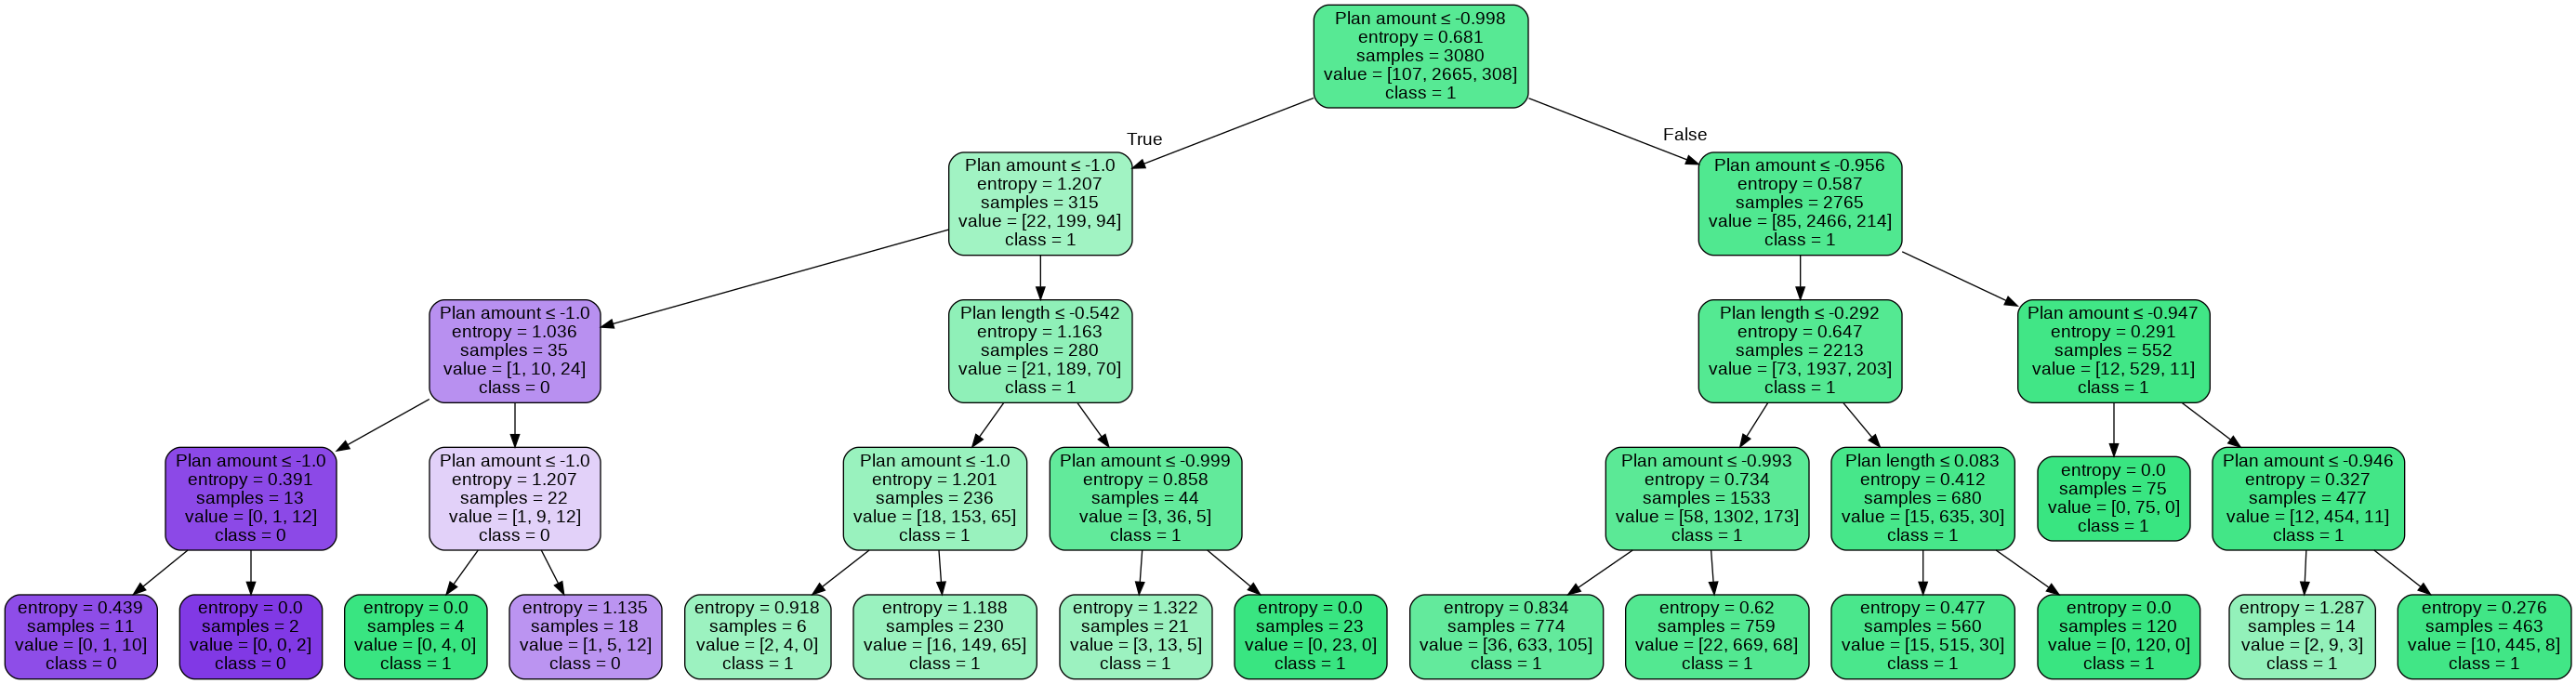

In [ ]:
dot_data = StringIO()

tree.export_graphviz(model
              , out_file = dot_data
              , filled = True
              , rounded = True
              , special_characters = True
              , feature_names = feature_cols
              , class_names = class_names
                    )

graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 

graph.write_png('prediction.png')

Image(graph.create_png())

### Feature Importance

### Estimate Class Probabilities

In [ ]:
model.predict_proba([[0.5, 0.5]])

array([[0.02159827, 0.96112311, 0.01727862]])

In [ ]:
model.predict([[0.5, 0.5]])

array([1.])

In [ ]:
confmtrx = np.array(confusion_matrix(y_test, y_pred))

pd.DataFrame(confmtrx, index=['Overspending','Underspending','On_Track'],
columns=['predicted_Overspending', 'predicted_Underspending', 'predicted_On_Track'])

,predicted_Overspending,predicted_Underspending,predicted_On_Track
Overspending,0,47,1
Underspending,0,1136,4
On_Track,0,127,6


### Minimal Cost-Complexity Pruning Algorithm

In [ ]:
clf_pruned = DecisionTreeClassifier(criterion = "gini", max_depth=2, random_state=0, min_samples_leaf=5)
clf_pruned.fit(x_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=2, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

In [ ]:
preds_pruned = clf_pruned.predict(x_test)
preds_pruned_train = clf_pruned.predict(x_train)
print(accuracy_score(y_test,preds_pruned))
print(accuracy_score(y_train,preds_pruned_train))

0.8644965934897805
0.8698051948051948


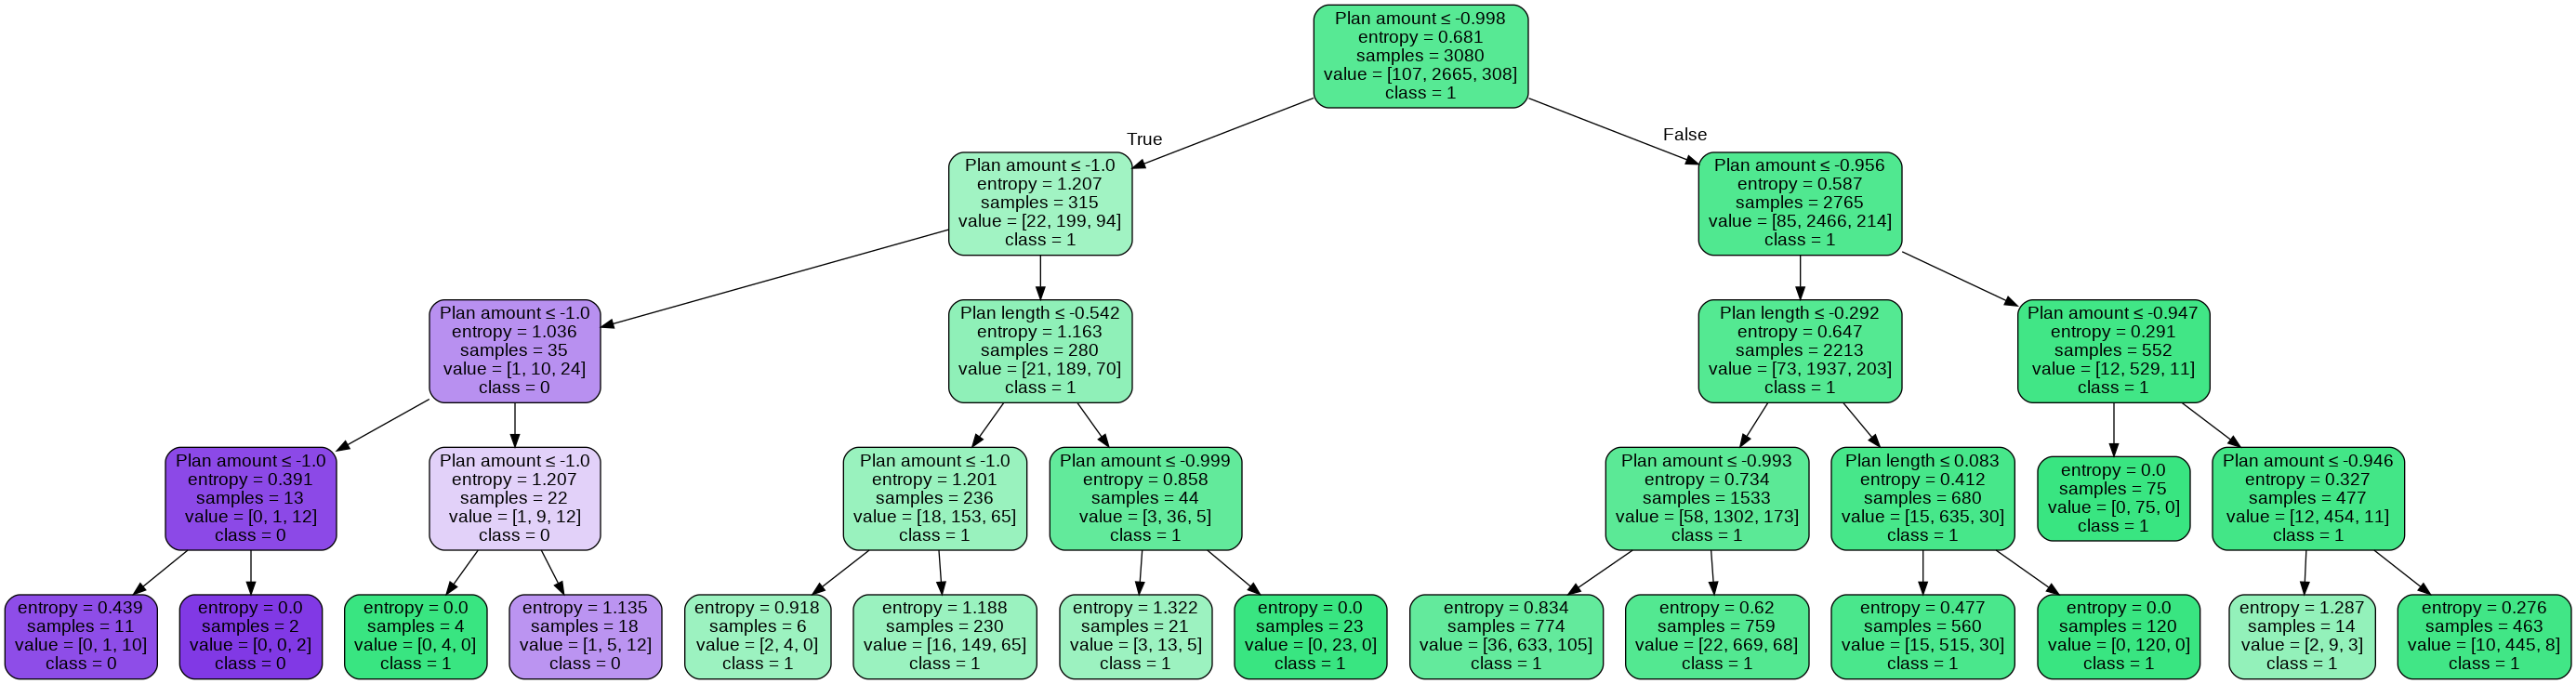

In [ ]:
dot_data = StringIO()

tree.export_graphviz(model
              , out_file = dot_data
              , filled = True
              , rounded = True
              , special_characters = True
              , feature_names = feature_cols
              , class_names = class_names
                    )

graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 

graph.write_png('prediction.png')

Image(graph.create_png())

In [ ]:
## Calculating feature importance
feat_importance = clf_pruned.tree_.compute_feature_importances(normalize=False)
feat_imp_dict = dict(zip(feature_cols, clf_pruned.feature_importances_))
feat_imp = pd.DataFrame.from_dict(feat_imp_dict, orient='index')
feat_imp.rename(columns = {0:'FeatureImportance'}, inplace = True)
feat_imp.sort_values(by=['FeatureImportance'], ascending=False).head()

,FeatureImportance
Plan amount,1.0
Plan length,0.0


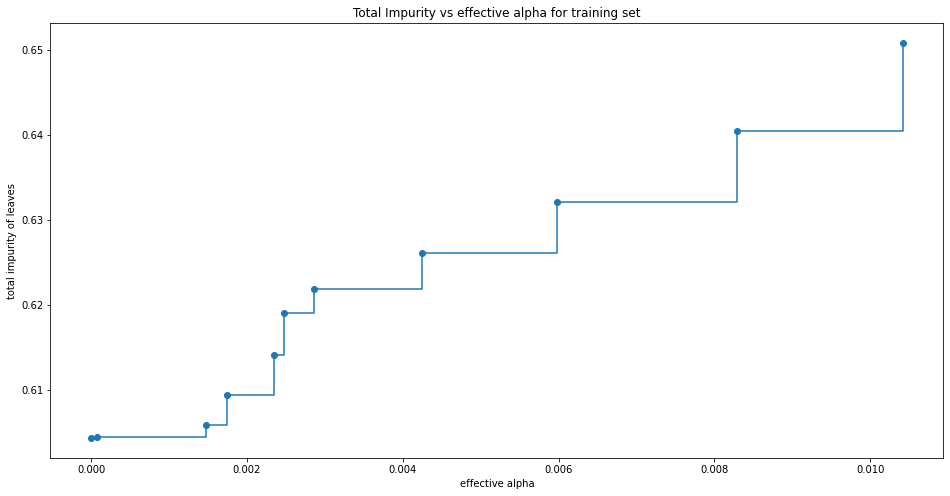

In [ ]:
path = model.cost_complexity_pruning_path(x_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
fig, ax = plt.subplots(figsize=(16,8));
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post");
ax.set_xlabel("effective alpha");
ax.set_ylabel("total impurity of leaves");
ax.set_title("Total Impurity vs effective alpha for training set");

In [ ]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(x_train, y_train)
    clfs.append(clf)
print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
      clfs[-1].tree_.node_count, ccp_alphas[-1]))

Number of nodes in the last tree is: 1 with ccp_alpha: 0.030440645158031354


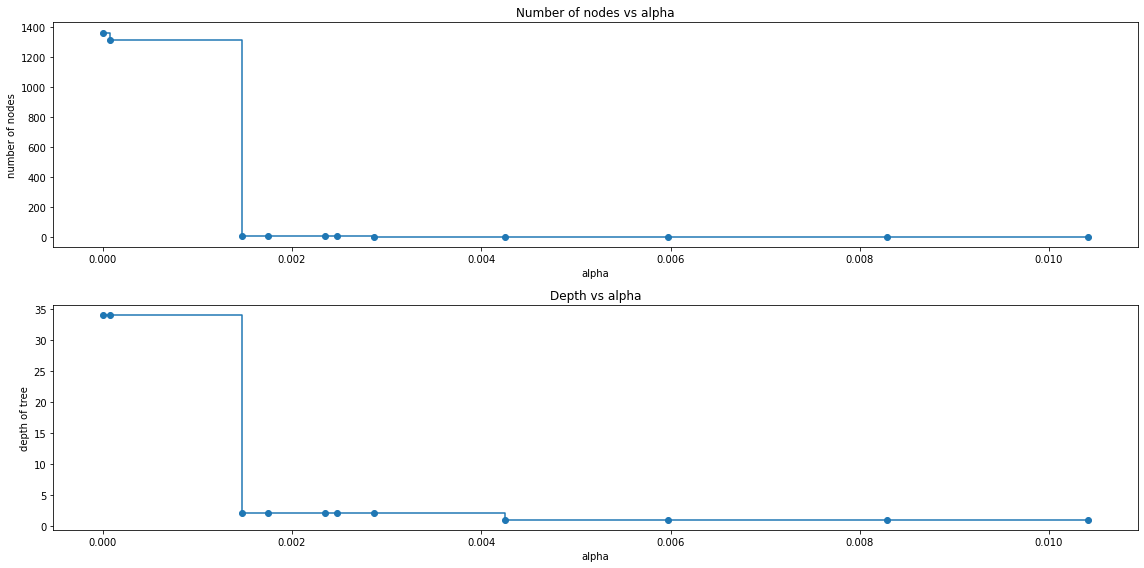

In [ ]:
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]
node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1,figsize=(16,8))
ax[0].plot(ccp_alphas, node_counts, marker='o', drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker='o', drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

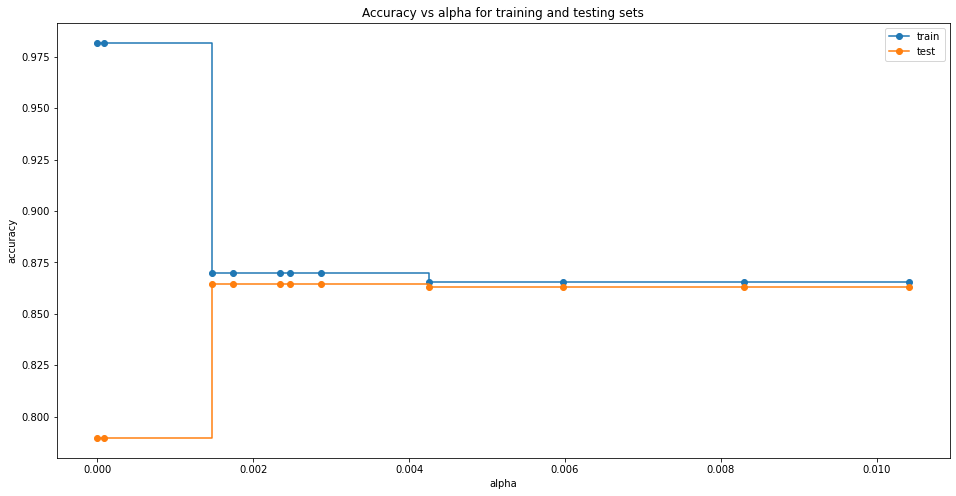

In [ ]:
fig, ax = plt.subplots(figsize=(16,8)); #-----------------Setting size of the canvas
train_scores = [clf.score(x_train, y_train) for clf in clfs]
test_scores = [clf.score(x_test, y_test) for clf in clfs]
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show()


In [ ]:
#compression_opts = dict(method='zip',
#                        archive_name='prediction.csv')

#df_prediction.to_csv('../dataSets/prediction.zip', compression=compression_opts)